# Projet MI205 - Détection de toppings de pizza


### Introduction

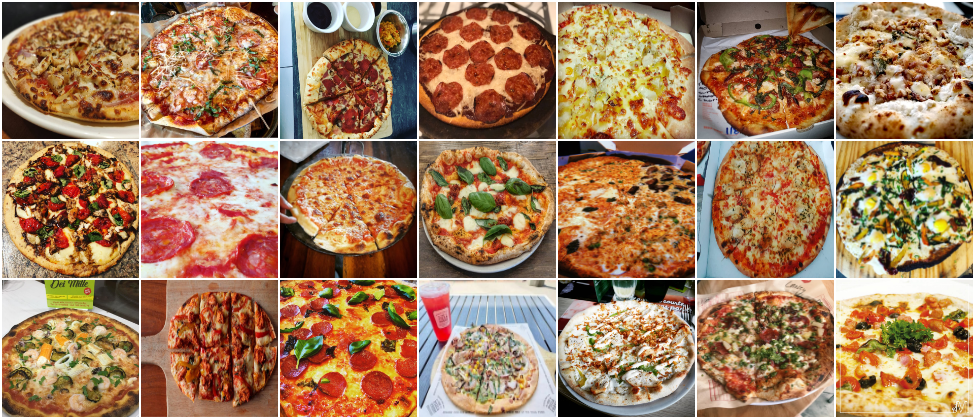

### Présentation du projet

Nous avons choisi le projet toppings de pizza pour avoir l'expérience d'une application concrète d'un réseau de neuronne. Pour ce faire, nous avons récupéré une base de donnée d'images réelles et de synthèses de pizza sur : http://pizzagan.csail.mit.edu/. 

L'objectif de ce projet est de labelliser des images de pizza en fonction de leur topping.

Pour cela, nous alllons dans un premiere temps entraîner et ajuster notre modèle de réseau de neuronne sur les images de synthèses, dont les caractéristiques de la pizza sont plus facilement reconnaissables (moins de bruit et de variations que sur des images réelles). Puis, nous testerons le modèle ainsi entraîné sur les images réelles ensuite avant de refaire des ajustements. (Cependant cette dernière étape n'a pas été possible car la base de donnée des images réelles est labellisée de manière différente, il faudra donc re-entraîner un réseau à partir de zéro).

### Analyse des données

La base de donnée d'images de synthèse est composée d'environ 5000 images toutes labellisées. Il y a 10 labels pour chaque pizza qui correspondent aux ingrédients dont peuvent être composés les toppings de pizza.

Chaque image est de taille 224*224 sur chaque couleur et est donc représentée par une matrice 3x224x224.



---



La base d'images réelles contient environ 10 000 images labellisées sur 13 labels, dans l'ordre: Pepperoni, Bacon, Champignons, Oignons, Poivre, Olives noires, Tomates, Epinards, Basilic frais, Roquette, Brocolis, Maïs et Ananas.

Chaque image est de taille 1080*1080 sur chaque couleur. Cela rend la base trop lourde pour être chargée telle quelle. Trois solutions sont alors possible:
  - Limiter le nombre d'image utilisée pour l'apprentissage: on aura alors un réseau potentiellement moins performant.
  - Ne pas charger les images en mémoire: l'apprentissage sera alors beaucoup plus long.
  - Modifier les images en amont (en les rognant et diminuant leur qualité par exemple) pour réduire l'espace nécessaire: risque de rendre certains toping impossible à reconnaitre, ce qui pourrait fausser les prédiction du réseau.




Au vu de ces difficultés, nous avons décidé de nous attaquer en priorité aux images de synthèse, afin de vérifier le bon fonctionnement de notre réseau sur des images simple. Cela nous a permi d'éviter tous problèmes pouvant venir de la base de donnée et d'ainsi ne pas perdre de temps à chercher si un problème provient du réseau ou des données. 





### Choix du réseau

Le choix du réseau pour un tel problème est crucial afin d'avoir de bons résultats à la fin. En effet, nous voulions initialement implémenter un SVM, mais cela est une mauvaise idée car la classification à faire ici est multi-label et non multi-classe. Cela signifie qu'une pizza n'appartient pas à une seule zone, elle peut appartenir à plusieurs classes et donc on ne peut pas séparer différentes zones par des hyperplans en utilisant des méthodes comme OneVsRest ou OneVsOne. Une possibilité aurait été de faire un SVM pour chacun des labels puis rassembler la décision de chacun de ces SVM mais cela nécessite l'entraînement de 10 SVM...

Une autre option que l'on a ensuite directement considérée est le CNN(Convolutionnal Neural Network). En effet, ce réseau de neuronnes est très adapté à la reconnaissance d'image, étant résistant aux petites translations, changements d'échelle, localisation de l'objet dans l'image ainsi qu'aux légers bruits, ce qui est idéal lorsque l'on s'attaque à des images réelles. 

Pour cela, on a testé et comparé notre propre CNN ainsi qu'un modèle fournit par Pytorch nommé EfficientNet.

 

## Prérequis

### Connexion au Drive

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/MI201_Pizza'

Mounted at /content/gdrive/


###Importation des librairies utiles

In [3]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Wed Jan 25 22:44:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Décompression des images dans le Drive

In [ ]:
#!unzip -q -u '/content/gdrive/MyDrive/MI201_Pizza/pizzaGANdata.zip' -d '/content/gdrive/MyDrive/MI201_Pizza/'

## Accès aux données

### Choix du lot d'image à utiliser

In [15]:
dataSetName = 'syntheticDataset'
#dataSetName = 'pizzaGANdata'

### Lecture des données

Lecture des indices des images d'entrainement et de test (On ne manipule que les indices, les images sont chargées lors de leur accès) et séparation du lot d'image d'entrainement en un lot d'entrainement et un lot de validation.

In [16]:
# Chemins d'accès aux données
if dataSetName == 'syntheticDataset':
  trainLabelPath = os.path.join(DATA_DIR, dataSetName + '/train/trainLabels.txt')
  testLabelPath = os.path.join(DATA_DIR, dataSetName + '/test/testLabels.txt')
else:
  trainLabelPath = os.path.join(DATA_DIR, dataSetName + '/imageLabels.txt')

# Récupération de tous les indices des images et de tous les labels correspondants
y_all = np.loadtxt(trainLabelPath)
x_all = np.arange(y_all.shape[0])

# Limite le nombre d'images (utile pour limiter la consommaton en RAM des images réelles)
'''
max_photo = 100
y_all = y_all[0:max_photo]
x_all = x_all[0:max_photo]
'''

print(x_all)
print(y_all)

# Création des set d'entraienemnt et de test
if dataSetName == 'syntheticDataset':
  y_test = np.loadtxt(testLabelPath)
  x_test = np.arange(y_test.shape[0])

  x_train = x_all
  y_train = y_all
else:
  x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_test.shape)

# Découpe du set d'entrainement en un set d'entrainement et un set de validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

print(x_train.shape)
print(y_train.shape)

[   0    1    2 ... 4968 4969 4970]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]]
(497, 10)
(3976,)
(3976, 10)


### Affichage d'une image

On vérifie que les images sont accessibles et que les toppings sont bien reconnaissables (ie que ces données sont utilisable)

0046.png


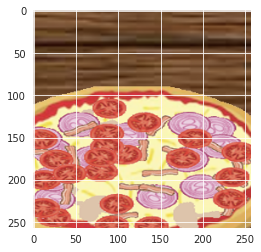

In [17]:
idx = 45

if dataSetName == 'syntheticDataset':
  img_name = "{:04d}.png".format(idx+1)
  img_path = os.path.join(DATA_DIR, dataSetName + '/train/images')
else:
  img_name = "{:05d}.jpg".format(idx+1)
  img_path = os.path.join(DATA_DIR, dataSetName + '/images')

print(img_name)
img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Stockage des images d'entrainement dans la mémoire

Stockage des images d'entrainement en mémoire, permettant d'éviter de devoir les charger depuis le Drive à chaque accès et accélérant ainsi la phase d'entrainement.

Les images chargées sont ensuite stockées dans un fichier numpy compressé sur le Drive, accélérant leur chargement futur.

In [18]:
if dataSetName == 'syntheticDataset':
  train_data_path = os.path.join(DATA_DIR, dataSetName + '/train')
  numpy_file_path = os.path.join(train_data_path, 'img_data_224.npz')
  img_name_format = "{:04d}.png"
  img_format = (224,224)
else:
  train_data_path=os.path.join(DATA_DIR, dataSetName)
  numpy_file_path = os.path.join(train_data_path, 'img_data_1080.npz')
  img_name_format = "{:05d}.jpg"
  img_format = (1080,1080)
print(numpy_file_path)


# Chargement des images si elles ont déjà été compressées
if (os.path.exists(numpy_file_path)):
  img_data_tensor = np.load(numpy_file_path)
  img_all = img_data_tensor['img_data']
else: # Sinon, chargement des images puis compression dans le Drive
  img_all = []
    
  for idx in tqdm(x_all):
      img_name = img_name_format.format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize(img_format)))
  
  img_all = np.array(img_all)

  # Sauvegarde des images compressées
  np.savez_compressed(numpy_file_path, img_data=img_all)

/content/gdrive/MyDrive/MI201_Pizza/syntheticDataset/train/img_data_224.npz


### Définition du Dataset

On définit le Dataset qui permettra de fournir les images au Dataloader. Ce dernier se charge notamment de découper les lots d'image en batch et de les fournir au réseau.

Ainsi le Dataset doit pouvoir retourner une image à partir de son indice (fonction __getitem__). On en profite pour appliquer une transformation à l'image avant de la fournir, permettant d'augmenter les variations du lot d'image et de rendre le reseau final plus robuste.

In [19]:
if dataSetName == 'syntheticDataset':
  default_img_path = '/content/gdrive/MyDrive/MI201_Pizza/' + dataSetName + '/train/images'
  img_name_format = "{:04d}.png"
else:
  default_img_path = '/content/gdrive/MyDrive/MI201_Pizza/' + dataSetName + '/images'
  img_name_format = "{:05d}.jpg"

class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path=default_img_path, img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = img_name_format.format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))

### Initialisation des Dataloaders

On définit maintenant les transformations à appliquer aux lots d'entrainement, de validartion et de test.

Puis on initialise les Dataset correspondant et on les passe aux Dataloader.

In [20]:
if dataSetName == 'syntheticDataset':
  train_data_path = img_path = os.path.join(DATA_DIR, dataSetName + '/train/images')
  test_data_path = img_path = os.path.join(DATA_DIR, dataSetName + '/test/images')
  input_size = 224
else:
  train_data_path = img_path = os.path.join(DATA_DIR, dataSetName + '/images')
  test_data_path = train_data_path
  input_size = 1080

batch_size = 25

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transformations à appliquer aux données d'entrainement
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

# Transformations à appliquer aux données de validation et de test
val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

# Initialisation du dataloader des données d'entrainement
img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

# Initialisation du dataloader des données de validation
img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

# Initialisation du dataloader des données de test
test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

### Visualisation de data loader

On vérifie que les images sont accessible par le Dataloader, que l'image retournée après application des transformations est toujours reconaissable (ie que les toppings sont toujours discernables) et que l'on peut charger un batch complet.

On récupère également la dimension de l'image, utile notamment pour connaitre la taille des layers successifs de notre CNN.

tensor([[[ 0.0227, -0.0972, -0.2684,  ..., -0.2342, -0.3369, -0.3712],
         [ 0.0227, -0.0972, -0.2684,  ..., -0.2342, -0.3369, -0.3541],
         [ 0.0227, -0.0801, -0.2513,  ..., -0.2171, -0.3198, -0.3541],
         ...,
         [ 0.0912,  0.1426,  0.1768,  ..., -0.2856, -0.0629,  0.0741],
         [ 0.0912,  0.1254,  0.1597,  ..., -0.2856, -0.0801,  0.0569],
         [ 0.0912,  0.1254,  0.1597,  ..., -0.2856, -0.0801,  0.0569]],

        [[-0.4951, -0.6176, -0.8102,  ..., -0.7227, -0.8277, -0.8627],
         [-0.4951, -0.6176, -0.7927,  ..., -0.7052, -0.8102, -0.8452],
         [-0.4951, -0.6001, -0.7752,  ..., -0.7052, -0.8102, -0.8452],
         ...,
         [-0.4251, -0.3901, -0.3375,  ..., -0.8803, -0.6352, -0.4776],
         [-0.4251, -0.3901, -0.3550,  ..., -0.8978, -0.6527, -0.4951],
         [-0.4251, -0.3901, -0.3725,  ..., -0.8978, -0.6527, -0.4951]],

        [[-0.7587, -0.8458, -1.0027,  ..., -1.0027, -1.1073, -1.1596],
         [-0.7413, -0.8284, -0.9853,  ..., -0

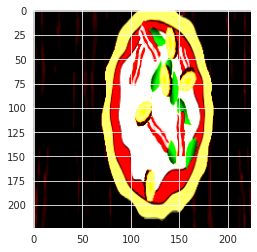

torch.Size([25, 3, 224, 224])


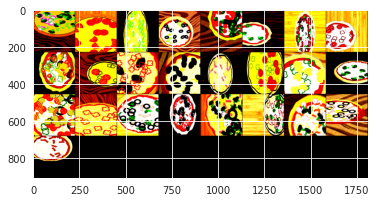

In [21]:
# Show dataset sample
x,y = test_set_raw[0]
print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

## Initialisation du réseau

### Définition de notre CNN

On définit un réseau de neurone convolutif dont on peut faire varier les paramètres (nombre de layer, taille des kernel de convolution, taille des hidden layer...) pour essayer d'obtenir les meilleurs prédictions.

In [22]:
class MonReseauCNN(nn.Module):
    def __init__(self, nlabel):
        super(MonReseauCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size = 3, padding=1)
        self.final = nn.Linear(6272,nlabel)
      

    def forward(self, x):
      x = F.leaky_relu(self.conv1(x))
      x = F.max_pool2d(x,kernel_size=2,stride=2)
      x = F.leaky_relu(self.conv2(x))
      x = F.max_pool2d(x,kernel_size=2,stride=2)
      x = F.leaky_relu(self.conv3(x))
      x = F.max_pool2d(x,kernel_size=2,stride=2)
      x = F.leaky_relu(self.conv4(x))
      x = F.max_pool2d(x,kernel_size=2,stride=2)
      x=x.view(-1,6272)
      x = self.final(x)
      return x

### Choix du réseau utilisé

On initialise le réseau que l'on va entrainer

In [ ]:
'''
nlabel = y_all.shape[1]
network = MonReseauCNN(nlabel = nlabel)

# Nom du reseau utilisé
tag = "simpleCNN"
'''

'\nnlabel = y_all.shape[1]\nnetwork = MonReseauCNN(nlabel = nlabel)\n\n# Nom du reseau utilisé\ntag = "simpleCNN"\n'

Alternativement, on charge ici un autre CNN fournit par Pytorch, efficientNet, pour comparer les résultats avec notre CNN.

In [23]:

nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

# Nom du reseau utilisé
tag = "efficientNet"


## Apprentissage

Entrainement du réseau sur les images de test et mesure de sa performance

### Définition de la fonction d'entrainement

Fonction générique permettant d'entrainer un réseau

In [24]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import random
import copy

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, device, num_epochs=5):

    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []

    # On fait les calculs sur GPU si possible
    model = model.to(device)

    
    # Itération à travers les epoch
    for epoch in range(num_epochs):
      model.train()
      print("Epoch {}".format(epoch))

      perf_label_train = np.zeros((1,nlabel))

      # Phase d'apprentissage
      for inputs, targets in trainloader:   ## on itere sur les données 
        inputs = inputs.to(device)
        targets = targets.to(device)

        mespredictions = model(inputs)  ## on les fait rentrer dans le réseau
        loss = criterion(mespredictions,targets.float())  ## on compare la sortie courante à la sortie voulue

        train_losses.append(loss)

        # Calcul du nombre de prédiction correctes
        train_mespredictions_np = mespredictions.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        train_pred = (train_mespredictions_np > 0) # Tableau binaire de prédiction

        perf_label_train = perf_label_train + (targets_np == train_pred).sum(axis=0) # Nombre de prédictions correctes

        # Actualisation des poids du réseau
        optimizer.zero_grad() ## supprime les gradients courants
        loss.backward() ## le gradient -- la magie par rapport à comment c'était long en court :-)
        optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue


        if random.randint(0,90)==0:
          print("\tloss=",loss) ## on affiche pour valider que ça diverge pas
      
      scheduler.step()
      
      # Affichage des performances pour chaque label sur le set d'entrainement
      oa_train = perf_label_train / len(trainloader.dataset)
      train_perf.append(oa_train)
      print("\tTrain perf=",oa_train)

      # Calcul des performances pour chaque label sur le set de validation
      model.eval()

      perf_label_test = np.zeros((1,nlabel))

      # tell not to reserve memory space for gradients (much faster)
      with torch.no_grad():
        for inputs, targets in valloader:   ## on itere sur les données de validation
          inputs = inputs.to(device)
          targets = targets.to(device)

          test_mespredictions = model(inputs)

          test_mespredictions_np = test_mespredictions.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          test_pred = (test_mespredictions_np > 0)

          perf_label_test = perf_label_test + (targets_np == test_pred).sum(axis=0)

      # Affichage des performances pour chaque label sur le set de validation
      oa_test = perf_label_test / len(valloader.dataset)
      test_perf.append(oa_test)
      print("\tValidation perf=",oa_test)

    return model, train_perf, test_perf, train_losses

  

### Récupération du réseau depuis le Drive (s'il existe)

In [ ]:
# Récupération du réseau précédemment entrainé si stocké dans le Drive
if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

Resume from last learning step


### Entrainement du réseau

Définition de l'optimizer (notamment choix du learning rate **lr**) et de la fonction **loss**, puis appel de la fonction d'entrainement et stockage du réseau entrainé sur le Drive.

In [25]:
from torch.optim import Adam

# Définition des Dataloader
trainloader=train_dataloader
valloader=val_dataloader

# Passage du réseau sur GPU si disponible
network.to(device)

# Définition des paramètres d'apprentissage
optimizer = Adam(network.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

nlabel = y_all.shape[1]
max_epoch = 20

# Apprentissage 
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, device, num_epochs=max_epoch)

# Sauvegarde du réseau entrainé sur le Drive
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

# Affichage des performance du réseau au cours de l'entrainement
print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

Epoch 0
	loss= tensor(5.8652, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(4.7004, device='cuda:0', grad_fn=<DivBackward1>)
	Train perf= [[0.81715292 0.68410463 0.73742455 0.92178068 0.7195674  0.79929577
  0.84909457 0.79426559 0.83475855 0.89738431]]
	Validation perf= [[0.89045226 0.85527638 0.88341709 0.9798995  0.78492462 0.84623116
  0.88743719 0.87336683 0.84824121 0.91959799]]
Epoch 1
	loss= tensor(3.8454, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(4.5432, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(4.5261, device='cuda:0', grad_fn=<DivBackward1>)
	Train perf= [[0.8832998  0.81589537 0.86644869 0.95598592 0.80482897 0.86493964
  0.91423541 0.902666   0.87173038 0.92002012]]
	Validation perf= [[0.86934673 0.93165829 0.91457286 0.97889447 0.88040201 0.89145729
  0.93266332 0.89346734 0.85125628 0.95376884]]
Epoch 2
	loss= tensor(4.8625, device='cuda:0', grad_fn=<DivBackward1>)
	Train perf= [[0.8943662  0.83576459 0.89839034 0.96604628 0.8584004  0.

##Vérification

### Evolution lors de l'entrainement

Affichage de l'évolution des performances au cours de l'entrainement.

Cela permet de détecter un sous-entrainement (courbes de validation et d'entrainement proches de 0) et un overfitting (courbes d'entrainement proche de 1 mais courbe de validation diminue).

On affiche également la fonction **loss** pour vérifier qu'elle diminue bien au cours de l'apprentissage.

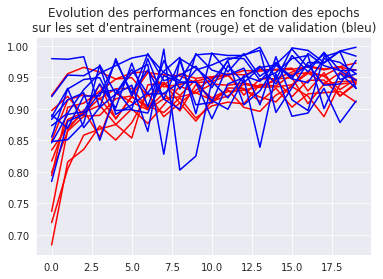

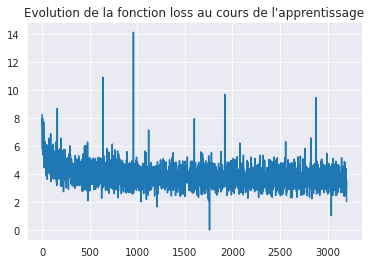

In [26]:
# Affichage de l'évolution des performances sur les set d'entrainement (rouge) et de validation (bleu) au cours des epoch (1 courbe = 1 label)
for j in range(0,len(train_error[0])):
  plt.plot(np.array(train_error)[:,j], 'r')
  plt.plot(np.array(test_error)[:,j], 'b')

plt.title("Evolution des performances en fonction des epochs\nsur les set d'entrainement (rouge) et de validation (bleu)")
plt.show()

# Affichage de l'évolution de la fonction loss
t_loss = []

for tl in train_losses:
  t_loss.append(tl.cpu().detach())

plt.plot(t_loss)
plt.title("Evolution de la fonction loss au cours de l'apprentissage") 
plt.show()

### Test du réseau

Application du réseau aux données de test et mesure de sa performance

In [27]:
testloader = test_dataloader

# Passe le réseau en mode évaluation (permet une prédiction plus rapide)
network.eval()

perf_label_test = np.zeros((1,nlabel))

# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)

        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # compute the predictions
        pred = (outputs_np > 0)

        # update the performance
        perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

# Prints the performance (per label)

oa_test = perf_label_test / len(testloader.dataset)
print("\nTest performance=",oa_test)

100%|███████████████████████████████████████████| 20/20 [02:25<00:00,  7.28s/it]


Test performance= [[0.94366197 0.9778672  0.91750503 0.99195171 0.97384306 0.94969819
  0.95372233 0.99597586 0.94768612 0.96981891]]


## Conclusion

On remarque que les résultats données par les 2 modèles de CNN sont très différents. Due aux difficultées à trouver de bons hyperparamètres pour notre propre CNN (nombres de convolutions, filtres, pooling), les résultats étaient bons pour certains labels (allant jusquà 90% de bonnes classifications) mais d'autres labels étaient bloqués vers 45 à 60% de bonnes classifications.

Le model EfficientNet est quant à lui bien mieux optimisé et efficace. Il nous permet d'atteindre rapidement un taux de réussite supérieur à 90% pour tous les labels après 20 epochs (lr=0.0005).

On remarque qu'avec un learning rate de lr=0.00001, on peut atteindre des résultats similaires pour certains labels. Cela requiert cependant 40 epochs et certains labels n'atteignent que 70% de réussite. 

En conclusion, il nous est maintenant possible de détecter les toppings de pizza synthétique grâce au CNN qui semble être un bon candidat pour ce type d'application. Même si nous n'avons pas eu la chance de pouvoir tester EfficientNet sur le dataset d'images réelles, nous pensons qu'il pourrait également atteindre de telles performances après un apprentissage potentiellement plus long. 